In [1]:
import matplotlib
import numpy as np
import pysptk
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import librosa.display

## Load audio file

In [2]:
fs, x = wavfile.read(pysptk.util.example_audio_file()) # treba uploadati neku .wav s kolegija
assert fs == 16000 #što je fs?
x = x.astype(np.float64) # što je x?
print(x.shape)

(64000,)


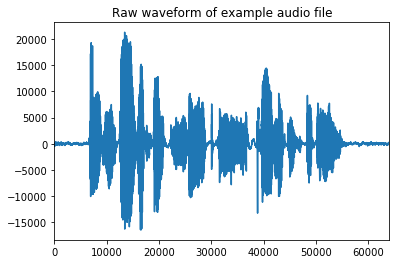

In [14]:
plt.plot(x)
plt.xlim(0, len(x))

#koristeći librosu
#librosa.display.waveplot(x, sr=fs) # što je sr? spectrum nešto?

plt.title("Raw waveform of example audio file")
Audio(x, rate=fs) #što je točno Audio display? pogledati dokumentaciju 

# Windowing

Text(0.5, 1.0, 'a windowd time frame')

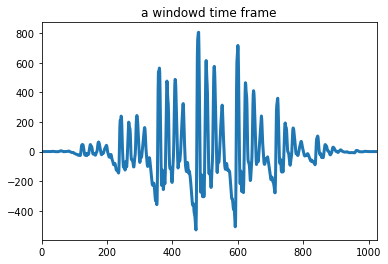

In [21]:
#short sagment - pick a short sagment
pos = 40000
frame_length = 1024

hop_length = 80 # što je hop_length?

xw = x[pos:pos+frame_length] * pysptk.blackman(frame_length)

frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T

#što je librosa.util.frame?

# frames = x[pos:pos+frame_length] * pysptk.blackman(frame_length)

frames *= pysptk.blackman(frame_length)

assert frames.shape[1] == frame_length # što ovo radi?
plt.plot(xw, linewidth = 3.0)
plt.xlim(0, frame_length)
plt.title("a windowd time frame")

### Plotting utility

In [6]:
def pplot(sp, envelope, title="no title"):
    plt.plot(sp, "b-", linewidth=2.0, label="Original log spectrum 20log|X(w)|")
    plt.plot(20.0/np.log(10)*envelope, "r-", linewidth=3.0, label=title)
    plt.xlim(0, len(sp))
    plt.xlabel("frequency bin")
    plt.ylabel("log amplitude")
    plt.legend(prop={'size': 20})

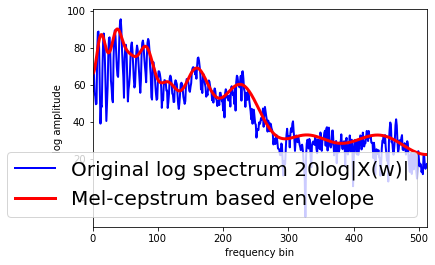

In [7]:
#Spectrum for a windowed signal

sp = 20*np.log10(np.abs(np.fft.rfft(xw)))

mgc = pysptk.mcep(xw, 20, 0.41)
pplot(sp, pysptk.mgc2sp(mgc, 0.41, 0.0, frame_length).real, title="Mel-cepstrum based envelope")

#zašto je 0.41? a u Lineaer frequency cepstrum based envelope je 0.0

In [8]:
## Source excertation - što je to?

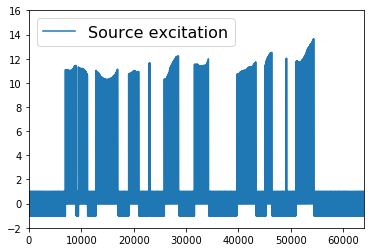

In [9]:
pitch = pysptk.swipe(x.astype(np.float64), fs=fs, hopsize=hop_length, min=60, max=240, otype="pitch")
source_excitation = pysptk.excite(pitch, hop_length)

# što točno rade swipe i excite
                            
plt.plot(source_excitation, label="Source excitation")
plt.xlim(0, len(source_excitation))
plt.ylim(-2, 16)
plt.legend(prop={'size': 16});

In [10]:
##Synthesis from mel-cepstrum

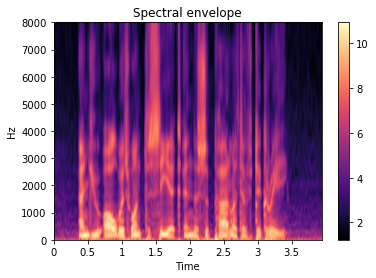

In [11]:
order = 25 # zašto je order 25?
alpha = 0.41 #zašto je alpha 0.41?

mc = pysptk.mcep(frames, order, alpha)
logH = pysptk.mgc2sp(mc, alpha, 0.0, frame_length).real
librosa.display.specshow(logH.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
plt.colorbar()
plt.title("Spectral envelope");

In [12]:
## Source excitation generation

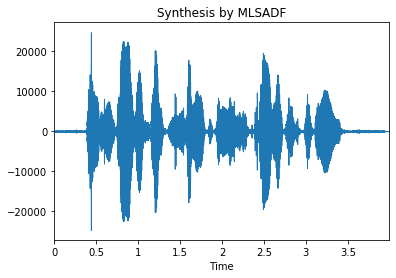

In [13]:
from pysptk.synthesis import MLSADF, Synthesizer

# Convert mel-cepstrum to MLSADF coefficients - "mel log spectrum approximation digital filter" that wraps mlsadf

b = pysptk.mc2b(mc, alpha)

synthesizer = Synthesizer(MLSADF(order=order, alpha=alpha), hop_length)

x_synthesized = synthesizer.synthesis(source_excitation, b)

librosa.display.waveplot(x_synthesized, sr = fs)
plt.title("Synthesis by MLSADF")
Audio(x_synthesized, rate=fs)